# 3104 Assignment 1
### [30 Marks, 20%]

## Import libraries

In [ ]:
from IPython.display import Markdown
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
np.random.seed(42)

In [ ]:
# Global variables
train_svm_models = False

## Load dataset

In [ ]:
trainingset = np.loadtxt('training.csv', delimiter=',')
testingset = np.loadtxt('test.csv', delimiter=',')
trainingset

## Split data

In [ ]:
n_inputs = 2304 # images are 48 x 48
n_classes = 7 # 7 classes - as defined below
img_dim = 48 # each input image dimension, width and height are both 48

x_training = trainingset[:, 0:n_inputs] # Extract the first 2304 elements - the image
y_training = trainingset[:, n_inputs:n_inputs + n_classes] # Extract the last 7 elements - a one hot category encoding

x_testing = testingset[:, 0:n_inputs] # Extract the first 2304 elements - the image
y_testing = testingset[:, n_inputs:n_inputs + n_classes] # Extract the last 7 elements - a one hot category encoding

x_training = x_training.reshape(x_training.shape[0], 48, 48) # Make samples image shaped
x_testing = x_testing.reshape(x_testing.shape[0], 48, 48) # Make samples image shaped

In [ ]:
def get_emotion(whichemotion):
    if whichemotion.shape[0] == 1:
        indx = whichemotion[0]
    else:
        indx = np.argmax(whichemotion)
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

In [ ]:
print("X training shape", x_training.shape)
print("y training shape", y_training.shape)

print("X testing shape", x_testing.shape)
print("y testing shape", y_testing.shape)

sampleindex = np.random.randint(0,1000)
sample = x_training[sampleindex, :]
sample = sample.reshape(48, 48)

plt.imshow(sample, cmap='gray')
plt.show()
print('facial emotion: %s' % get_emotion(y_training[sampleindex, :]))

# Part I : Happy or Sad

## For this part you will consider a binary classification problem - categorizing faces as happy or sad

[1 Mark] a. Sample from the data loaded above to include only the happy or sad cases

In [ ]:
emotion_columns = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

def create_binary_classification_dataframe(dataset):
    """
    Create a datafrane from the dataset
    """

    # Create a dataframe with all the training data
    X_df = pd.DataFrame(dataset[:, :n_inputs])

    # Create a dataframe with all the emotion data
    y_df = pd.DataFrame(dataset[:, n_inputs:n_inputs + n_classes], columns=emotion_columns)

    # Concatenate the two dataframes
    df = pd.concat([X_df, y_df], axis=1)

    # Filter only happy and sad
    df_sample = df[(y_df['happy'] == 1) | (y_df['sad'] == 1)].copy(deep=True)

    # Create emotion column, 1 for happy and 0 for sad
    df_sample['emotion'] = y_df[['happy', 'sad']].apply(lambda row: 1 if row['happy'] == 1 else 0, axis=1)

    # Remove all of the initial emotion columns
    df_sample.drop(emotion_columns, axis=1, inplace=True)

    return df_sample

# Create the dataframes for training and testing
df_binary_train = create_binary_classification_dataframe(trainingset)
df_binary_test = create_binary_classification_dataframe(testingset)

print("Binary train dataframe shape:", df_binary_train.shape)
print("Binary test dataframe shape:", df_binary_test.shape)
df_binary_train.head()

[4 Marks] b. Apply PCA and LDA to represent the faces, display a sample of a few faces for each case. You may consider using one or both of these in the steps that follow if they are of any value (this is for you to decide).

Scale the data

In [ ]:
def scale_dataframe(df_train: pd.DataFrame, df_test: pd.DataFrame) -> np.array:
    """
    Scale the data
    """

    # Create a standard scaler
    standar_scaler = StandardScaler()

    # Scale training data
    X_train_scaled = standar_scaler.fit_transform(df_train.drop('emotion', axis=1))

    # Scale testing data
    X_test_scaled = standar_scaler.transform(df_test.drop('emotion', axis=1))

    return X_train_scaled, X_test_scaled

X_train_binary_scaled, X_test_binary_scaled = scale_dataframe(df_binary_train, df_binary_test)
print("X train binary scaled", len(X_train_binary_scaled))
print("X test binary scaled", len(X_test_binary_scaled))

In [ ]:
y_binary_train = df_binary_train['emotion']
y_binary_test = df_binary_test['emotion']
y_binary_train.shape, y_binary_test.shape

PCA

In [ ]:
def plot_face_annotation(X_train: np.array, x: np.array, y: np.array, n_faces = 10):
    """
    Plot faces with annotations
    ---
    Args
    ...
    X_train: np.array - training data
    x: np.array - x values
    y: np.array - y values
    n_faces: int - number of faces to plot, default 10
    """
    
    # Get # of faces to plot
    indexes = np.random.randint(0, X_train.shape[0], 10)

    # Configuration of bboxprops
    bboxprops = dict(
        boxstyle="round,pad=0.1",
        edgecolor='000',
        linewidth=1
    )
    for i in indexes:

        # Create image box
        imagebox = OffsetImage(X_train[i].reshape(48, 48), zoom=0.5, cmap='gray')

        # Create annotation box
        ab = AnnotationBbox(
            offsetbox=imagebox,
            xy=(x[i], y[i]), # Position of the face X, Y
            bboxprops=bboxprops,
            frameon=True
        )

        # Add annotation box to the plot
        plt.gca().add_artist(ab)

In [ ]:
def create_pca_2d(X_train: np.array, n_components: int, colors_map: dict[str], plot_chart: bool = False) -> None:
    """
    Create a PCA, plot the PCA and return the PCA instance
    ---
    Args
    ...
    X_train: np.array - training data
    n_components: int - number of components to use
    colors_map: np.array - colors to use in the plot
    """

    # Create a PCA instance and fit the data
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_train)

    # Plot the PCA
    if plot_chart:
        plt.figure(figsize=(14, 10))
        plt.scatter(
            X_pca[:, 0], # Component 1
            X_pca[:, 1], # Component 2
            c=colors_map, 
            edgecolor='k',
            s=30
        )
        plt.legend(['Happy', 'Sad'])
        plt.title('PCA')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plot_face_annotation(X_train, X_pca[:, 0], X_pca[:, 1], 10)
        plt.show()

    return pca

In [ ]:
binary_pallete = {1: 'c', 0: 'm'} # Colors, cyan = happy, magenta = sad
binary_colors_map = df_binary_train['emotion'].map(binary_pallete).values
binary_pca_2_components = create_pca_2d(X_train_binary_scaled, 2, binary_colors_map, True)

LDA

In [ ]:
def create_binary_lda(X_train: np.array, y_df: pd.DataFrame, n_components: int, colors_map) -> None:
    """
    Create a LDA, plot the result and return the LDA instance
    ---
    Args
    ...
    X_train: np.array - training data
    y_df: pd.DataFrame - training labels
    n_components: int - number of components
    colors_map: dict - colors map for the emotions
    """
    lda = LDA(n_components=n_components)

    # Transform the scaled data using LDA
    X_lda = lda.fit_transform(X_train, y_df.to_numpy())
    
    # Create the legend for the different emotions
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=emotion) for emotion, color in colors_map.items()]

    x = X_lda
    y = np.zeros(len(X_lda))
    c = y_df.map(colors_map).values

    # Visualize the LDA result
    plt.figure(figsize=(16, 3))
    plt.scatter(x=x, y=y, c=c, cmap='viridis', edgecolor='k', s=40)
    plt.title('LDA')
    plt.colorbar()
    plt.legend(handles=handles, title="Emotion")
    plt.xlabel('Linear Discriminant 1')
    plot_face_annotation(X_train, x, np.array([0.02] * len(X_lda)), 20)
    plt.show()

    return lda

In [ ]:
binary_lda_1_component = create_binary_lda(X_train_binary_scaled, df_binary_train['emotion'], 1, binary_pallete)

[2 Marks] c. Apply naive Bayes to classify faces as happy or sad. Report your accuracy.

In [ ]:
def describe_binary_confusion_matrix(model, X_train, y_train):
    """
    Create a confusion matrix
    ---
    Args
    ...
    model: object - model to evaluate
    X_train: np.array - training data
    y_train: np.array - training labels
    """

    # Predict values for training data
    y_pred = model.predict(X_train)

    # Calculate confusion matrix
    cm = confusion_matrix(y_train, y_pred)

    # Convert data to dataframe to plot
    cm_df = pd.DataFrame(cm,
                         index = ['Real Negative', 'Real Positive'],
                         columns = ['Predicted Negative', 'Predicted Positive'])

    # Plot confusion matrix
    plt.figure(figsize=(4,4))
    sns.heatmap(cm_df, cmap='Blues', fmt='g', annot=True, cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('Observed Label')
    plt.xlabel('Predicted Label')
    plt.show()

    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]

    # Compute precision
    precision = TP / (TP + FP)
    print(f"Precision: {precision}")
    Markdown(f"$$\\frac{{TP}}{{TP + FP}} \\rightarrow \\frac{{{TP}}}{{{TP} + {FP}}} \\rightarrow {TP/(TP+FP)}$$")

    # Compute recall
    recall = recall_score(y_train, y_pred)
    print(f"Recall: {recall}")
    Markdown(f"$$\\frac{{TP}}{{TP + FN}} \\rightarrow \\frac{{{TP}}}{{{TP} + {FN}}} \\rightarrow {TP/(TP+FN)}$$")

    # Compute accuracy
    accuracy = accuracy_score(y_train, y_pred)
    print(f"Accuracy: {accuracy}")
    Markdown(f"$$\\frac{{TP + TN}}{{TP + TN + FP = FN}} \\rightarrow \\frac{{{TP} + {TN}}}{{{TP} + {TN} + {FP} + {FN}}} \\rightarrow {(TP+TN)/(TP+TN+FP+FN)}$$")

    # Compute F1 score
    f1 = 2 * (precision * recall) / (precision + recall)
    print(f"F1 score: {f1}")
    Markdown(f"$$2*\\frac{{Precision * Recall}}{{Precision + Recall}} \\rightarrow \\frac{{{precision} * {recall}}}{{{precision} + {recall}}} \\rightarrow {2*((precision*recall)/(precision+recall))}$$")

In [ ]:
def train_model(model: any, X_train: np.array, X_test: np.array, y_train: np.array, y_test: np.array) -> float:
    """
    Train a model and calculate the accuracy
    ---
    Args:
    ...
        model: any - model to train
        X_train:  training data
        X_test: np.array - testing data
        y_train: np.array - training labels
        y_test: np.array - testing labels
    """

    # Train the model
    model.fit(X_train, y_train)

    # Predict values
    y_pred = model.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return model, accuracy

In [ ]:
def train_naive_bayes(X_train: np.array, X_test: np.array, y_train: np.array, y_test: np.array) -> float:
    """
    Create a Naive Bayes model
    ---
    Args:
    ...
        X_train:  training data
        X_test: np.array - testing data
        y_train: np.array - training labels
        y_test: np.array - testing labels
    """
    return train_model(GaussianNB(), X_train, X_test, y_train, y_test)

In [ ]:
# Train the model using scaled data
binary_naive_bayes, acc = train_naive_bayes(X_train_binary_scaled, X_test_binary_scaled, y_binary_train, y_binary_test)

In [ ]:
# Transform the data using PCA and LDA

# PCA
X_train_binary_pca = binary_pca_2_components.transform(X_train_binary_scaled)
X_test_binary_pca = binary_pca_2_components.transform(X_test_binary_scaled)

# LDA
X_train_binary_lda = binary_lda_1_component.transform(X_train_binary_scaled)
X_test_binary_lda = binary_lda_1_component.transform(X_test_binary_scaled)

In [ ]:
# Scaled (Original)
print("Original")
binary_naive_bayes_original, acc = train_naive_bayes(X_train_binary_scaled, X_test_binary_scaled, y_binary_train, y_binary_test)

# PCA
print("\nPCA")
binary_naive_bayes_pca, acc = train_naive_bayes(X_train_binary_pca, X_test_binary_pca, y_binary_train, y_binary_test)

# LDA
print("\nLDA")
binary_naive_bayes_lda, acc = train_naive_bayes(X_train_binary_lda, X_test_binary_lda, y_binary_train, y_binary_test)

_Using PCA, the accuracy increate slightly to 59.82%, but LDA increase it to 67.51%_

[2 Marks] d. Apply Logistic regression to classify faces as happy or sad. Report the accuracy.

In [ ]:
def train_logistic_regression(X_train: np.array, X_test: np.array, y_train: np.array, y_test: np.array) -> float:
    """
    Create a Naive Bayes model
    ---
    Args:
    ...
        X_train:  training data
        X_test: np.array - testing data
        y_train: np.array - training labels
        y_test: np.array - testing labels
    """

    return train_model(LogisticRegression(), X_train, X_test, y_train, y_test)

In [ ]:
# Scaled (Original)
print("Original")
binary_logistic_original, acc = train_logistic_regression(X_train_binary_scaled, X_test_binary_scaled, y_binary_train, y_binary_test)

# PCA
print("\nPCA")
binary_logistic_pca, acc = train_logistic_regression(X_train_binary_pca, X_test_binary_pca, y_binary_train, y_binary_test)

# LDA
print("\nLDA")
binary_logistic_lda, acc = train_logistic_regression(X_train_binary_lda, X_test_binary_lda, y_binary_train, y_binary_test)

[2 Marks] e. Apply a Support Vector Machine to classify the faces as happy or sad. Choose parameters / arguments to try to maximize your accuracy. Report the accuracy.

In [273]:
def train_svm(X_train: np.array, X_test: np.array, y_train: np.array, y_test: np.array) -> float:
    """
    Create a Naive Bayes model
    ---
    Args:
    ...
        X_train:  training data
        X_test: np.array - testing data
        y_train: np.array - training labels
        y_test: np.array - testing labels
    """

    param_grid = {
        'C': [0.1, 1],
        'gamma': ['scale', 0.01, 0.1, 1],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }

    return train_model(GridSearchCV(SVC(), param_grid, cv=4, scoring='accuracy', n_jobs=-1), X_train, X_test, y_train, y_test)


In [277]:
binary_svm_original = None
if train_svm_models:
    binary_svm_original, acc = train_svm(X_train_binary_scaled, X_test_binary_scaled, y_binary_train, y_binary_test)
    if train_svm_models:
        joblib.dump(binary_svm_original, 'binary_svm_original.pkl')
else:
    binary_svm_original = joblib.load('binary_svm_original.pkl')


[1 Mark] f. Which of the approaches above allow you to reliably determine the degree of happiness or sadness (i.e. how happy or how sad)? Which do you trust the most?

According to the accuracy of the models, the best is SVM because it has the highest accuracy and in this case we need to get the proportion of correct predictions.

[2 Marks] g. Based on your answer to f. show the 5 happiest faces and the 5 saddest faces.

In [278]:
binary_scores = binary_svm_original.best_estimator_.decision_function(X_test_binary_scaled)
binary_scores[:5]

array([-1.13629455,  1.01449936,  0.24080313,  1.15407575, -0.36647174])

In [279]:
y_binay_pred = binary_svm_original.best_estimator_.predict(X_test_binary_scaled)

In [280]:
binnary_probabilities_df = pd.DataFrame({
    'index': range(len(binary_scores)),
    'pred': y_binay_pred,
    'score': binary_scores
})

happiest_faces = binnary_probabilities_df[binnary_probabilities_df["pred"] == 1].sort_values(by='score', ascending=False).head(5).index
saddest_faces = binnary_probabilities_df[binnary_probabilities_df["pred"] == 0].sort_values(by='score', ascending=False).head(5).index

Happiest

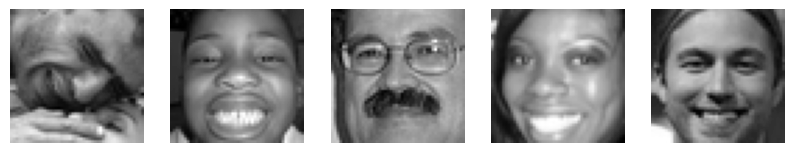

In [281]:
fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 2))
for ax, i in zip(axs, happiest_faces):
    image_data = df_binary_test.iloc[i, :n_inputs].to_numpy();
    img = image_data.reshape(48, 48)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

Saddest faces

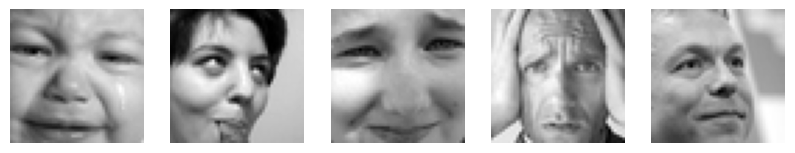

In [282]:
fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 2))
for ax, i in zip(axs, saddest_faces):
    image_data = df_binary_test.iloc[i, :n_inputs].to_numpy();
    img = image_data.reshape(48, 48)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

# Part II : Multi-class

## For this part you will repeat the tasks in Part I, but instead consider the multi-class problem and classify inputs according to all 7 classes. 

In [283]:
def create_multiclass_classification_dataframe(dataset):
    """
    Create a datafrane from the dataset
    """

    X_df = pd.DataFrame(dataset[:, :n_inputs])
    y_df = pd.DataFrame(dataset[:, n_inputs:n_inputs + n_classes], columns=emotion_columns)
    df = pd.concat([X_df, y_df], axis=1)
    df['emotion'] = y_df.apply(lambda row: get_emotion(row.to_numpy()), axis=1)
    return df

# Create the dataframes for training and testing
df_multiclass_train = create_multiclass_classification_dataframe(trainingset)
df_multiclass_test = create_multiclass_classification_dataframe(testingset)

df_multiclass_train.head()

0      1      2      3      4      5      6      7      8      9  ...  \
0   70.0   80.0   82.0   72.0   58.0   58.0   60.0   63.0   54.0   58.0  ...   
1  151.0  150.0  147.0  155.0  148.0  133.0  111.0  140.0  170.0  174.0  ...   
2  231.0  212.0  156.0  164.0  174.0  138.0  161.0  173.0  182.0  200.0  ...   
3   24.0   32.0   36.0   30.0   32.0   23.0   19.0   20.0   30.0   41.0  ...   
4    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

    2302   2303  angry  disgust  fear  happy  sad  surprise  neutral  emotion  
0  109.0   82.0    1.0      0.0   0.0    0.0  0.0       0.0      0.0    angry  
1  183.0  184.0    1.0      0.0   0.0    0.0  0.0       0.0      0.0    angry  
2  110.0  152.0    0.0      0.0   1.0    0.0  0.0       0.0      0.0     fear  
3  143.0  142.0    0.0      0.0   0.0    0.0  1.0       0.0      0.0      sad  
4   29.0   30.0    0.0      0.0   0.0    0.0  0.0       0.0      1.0  neutral  

[5 rows x 2312 columns]

In [284]:
df_multiclass_test.drop(columns=emotion_columns + ['emotion'])

0      1      2      3      4      5      6      7      8      9     \
0     254.0  254.0  254.0  254.0  254.0  249.0  255.0  160.0    2.0   58.0   
1     156.0  184.0  198.0  202.0  204.0  207.0  210.0  212.0  213.0  214.0   
2      69.0  118.0   61.0   60.0   96.0  121.0  103.0   87.0  103.0   88.0   
3     205.0  203.0  236.0  157.0   83.0  158.0  120.0  116.0   94.0   86.0   
4      87.0   79.0   74.0   66.0   74.0   96.0   77.0   80.0   80.0   84.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
3584  178.0  176.0  172.0  173.0  173.0  174.0  176.0  173.0  166.0  166.0   
3585   25.0   34.0   42.0   44.0   42.0   47.0   57.0   59.0   59.0   58.0   
3586  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0   
3587   33.0   25.0   31.0   36.0   36.0   42.0   69.0  103.0  132.0  163.0   
3588   61.0   63.0   59.0   75.0  151.0  159.0  166.0  161.0  143.0  170.0   

      ...   2294   2295   2296   2297   2298   2299   2300   2301   2302  \
0     ...   90.0   92.0   99.0   84.0   22.0    0.0    0.0   42.0  129.0   
1     ...  201.0  199.0  197.0  193.0  188.0  184.0  180.0  172.0  167.0   
2     ...   93.0   93.0   92.0   90.0   92.0   93.0   92.0   88.0   87.0   
3     ...  207.0  211.0  213.0  206.0  196.0  181.0  112.0   43.0   82.0   
4     ...   33.0   32.0   33.0   35.0   38.0   40.0   45.0   41.0   34.0   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
3584  ...   13.0   19.0   24.0   32.0   32.0   22.0   15.0   14.0   15.0   
3585  ...   70.0   67.0   70.0   92.0   80.0   74.0   33.0    9.0   12.0   
3586  ...   42.0   43.0   44.0   45.0   46.0   47.0   48.0   48.0   50.0   
3587  ...   12.0   11.0    9.0    8.0    6.0    4.0    4.0    4.0    5.0   
3588  ...   36.0   39.0   92.0  139.0  143.0  162.0  119.0  113.0  165.0   

       2303  
0     180.0  
1     161.0  
2      90.0  
3      86.0  
4      32.0  
...     ...  
3584   19.0  
3585   11.0  
3586   46.0  
3587    4.0  
3588  180.0  

[3589 rows x 2304 columns]

In [285]:
# Scale the data
X_multiclass_train_scaled, X_multiclass_test_scaled = scale_dataframe(
    df_multiclass_train.drop(columns=emotion_columns),
    df_multiclass_test.drop(columns=emotion_columns)
)
X_multiclass_train_scaled[:5]

array([[-0.60988232, -0.45922179, -0.40324932, ..., -0.08629621,
        -0.05737476, -0.41127695],
       [ 0.37236201,  0.40461631,  0.41101767, ...,  1.0387427 ,
         0.89140538,  0.88666892],
       [ 1.34247986,  1.16973007,  0.52376233, ..., -0.31906288,
        -0.04455341,  0.47947022],
       [-1.16770008, -1.05156793, -0.9794998 , ...,  0.37923713,
         0.37855125,  0.35222062],
       [-1.41022954, -1.44646535, -1.43047844, ..., -1.06908883,
        -1.08308302, -1.07297485]])

In [286]:
y_multiclass_train = df_multiclass_train['emotion']
y_multiclass_test = df_multiclass_test['emotion']
y_multiclass_train.shape, y_multiclass_test.shape

((28709,), (3589,))

[4 Marks] a. Apply PCA and LDA to represent the faces, display a sample of a few faces for each case. Produce a plot for PCA showing the cumulative variance captured by adding additional principal components (e.g. 1st PC, 1st + 2nd PC, etc.). On the same figure, plot the same curve for only happy and sad faces used in part 1.

PCA

In [287]:
emotion_colors = {
    'happy': 'c',
    'sad': 'm',
    'angry': 'r',
    'disgust': 'g',
    'fear': 'b',
    'surprise': 'y',
    'neutral': 'k'
}

create_pca_2d(X_multiclass_train_scaled, 2, df_multiclass_train['emotion'].map(emotion_colors).values)

PCA(n_components=2)

LDA

In [288]:
len(emotion_colors)

7

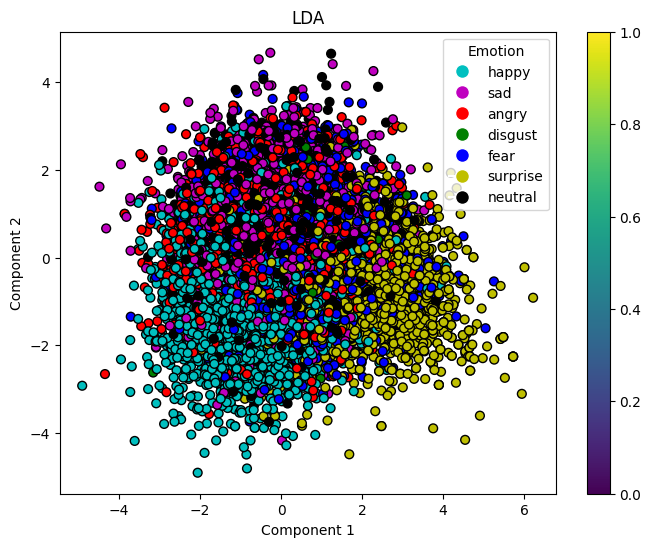

In [289]:
def create_multiclass_lda_2d(X_train: np.array, y_df: pd.DataFrame, colors_map)-> None:

    lda = LDA(n_components=2)

    # Transform the scaled data using LDA
    X_lda = lda.fit_transform(X_train, y_df.to_numpy())
    
    # Create the legend for the different emotions
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=emotion) for emotion, color in colors_map.items()]

    x = X_lda[:, 0],  # Component 1
    y = X_lda[:, 1],  # Component 2
    c = y_df.map(colors_map).values

    # Visualize the LDA result
    plt.figure(figsize=(8, 6))
    plt.scatter(x=x, y=y, c=c, cmap='viridis', edgecolor='k', s=40)
    plt.title('LDA')
    plt.colorbar()
    plt.legend(handles=handles, title="Emotion")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

create_multiclass_lda_2d(X_multiclass_train_scaled, df_multiclass_train['emotion'], emotion_colors)

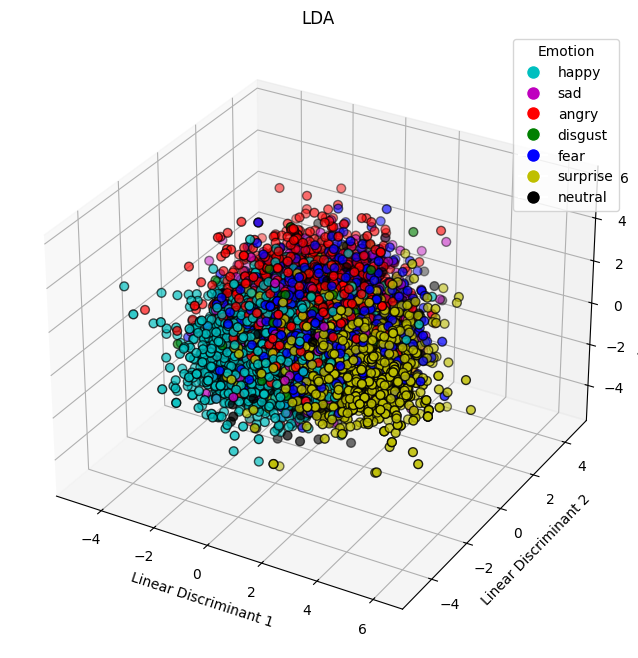

In [290]:
def create_multiclass_lda_3d(X_train: np.array, y_df: pd.DataFrame, colors_map)-> None:

    lda = LDA(n_components=3)
    X_mc_lda = lda.fit_transform(X_train, y_df.to_numpy())

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=emotion) 
            for emotion, color in emotion_colors.items()]

    c = y_df.map(colors_map).values

    # Visualize the LDA result
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(
        X_mc_lda[:, 0],  # Component 1
        X_mc_lda[:, 1],  # Component 2
        X_mc_lda[:, 2],  # Component 3
        c=c,
        edgecolor='k',
        s=40
    )
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=emotion) for emotion, color in emotion_colors.items()]

    ax.legend(handles=handles, title="Emotion")
    ax.set_title('LDA')
    ax.set_xlabel('Linear Discriminant 1')
    ax.set_ylabel('Linear Discriminant 2')
    ax.set_zlabel('Linear Discriminant 3')
    plt.show()

create_multiclass_lda_3d(X_multiclass_train_scaled, df_multiclass_train['emotion'], emotion_colors)

In [291]:
def create_multiclass_lda_3d_dinamyc(X_train: np.array, y_df: pd.DataFrame, colors_map)-> None:

    lda = LDA(n_components=3)
    X_mc_lda = lda.fit_transform(X_train, y_df.to_numpy())
    
    df_lda = pd.DataFrame(X_mc_lda, columns=['LD1', 'LD2', 'LD3'])
    df_lda['emotion'] = y_df.map(colors_map).values

    fig = px.scatter_3d(
        df_lda,
        x='LD1',
        y='LD2',
        z='LD3',
        color='emotion',
        color_discrete_map=colors_map,
        title='LDA with 3 components',
        labels={
            'LD1': 'Linear Discriminant 1',
            'LD2': 'Linear Discriminant 2',
            'LD3': 'Linear Discriminant 3'
        },
        size=[3] * len(df_lda),
        size_max=10
    )
    fig.update_layout(width=800, height=800)
    fig.show()

create_multiclass_lda_3d_dinamyc(X_multiclass_train_scaled, df_multiclass_train['emotion'], emotion_colors)

[2 Marks] b. Classify the faces using Naive Bayes and report your accuracy.

In [292]:
multiclass_naive_bayes_model, acc = train_naive_bayes(X_multiclass_train_scaled, X_multiclass_test_scaled, y_multiclass_train, y_multiclass_test)

Accuracy: 22.74%


Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.
DESCRIBE BRIEFLY HERE

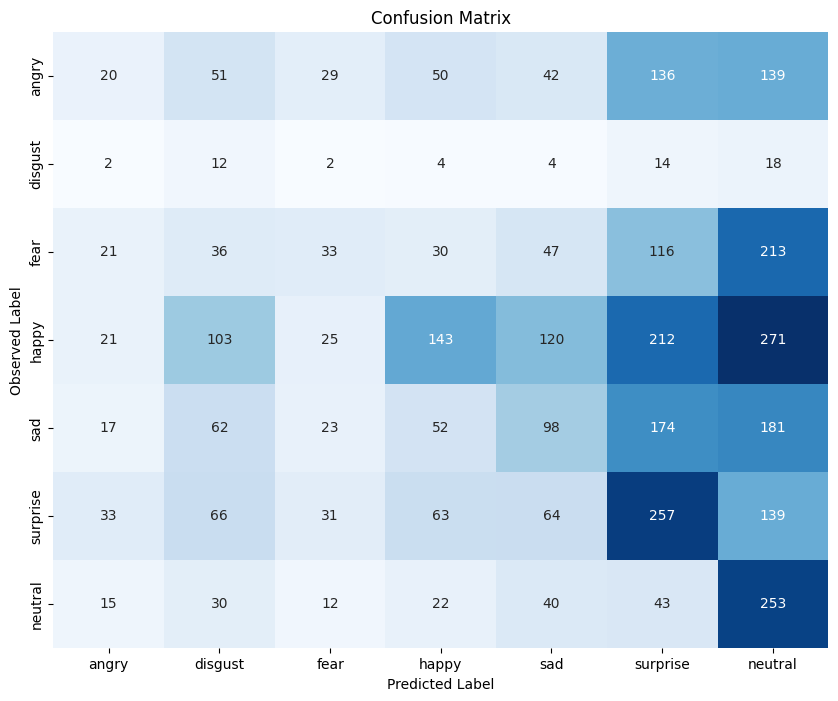

angry Precision: 0.15503875968992248


$$\frac{TP}{TP + FP} \rightarrow \frac{20}{20 + 109} \rightarrow 0.15503875968992248$$

angry Recall: 0.042826552462526764


$$\frac{TP}{TP + FN} \rightarrow \frac{20}{20 + 447} \rightarrow 0.042826552462526764$$

angry Accuracy: 0.8450821955976595


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{20 + 3013}{20 + 3013 + 109 + 447} \rightarrow 0.8450821955976595$$

angry F1 score: 0.06711409395973154


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.15503875968992248 * 0.042826552462526764}{0.15503875968992248 + 0.042826552462526764} \rightarrow 0.06711409395973154$$

disgust Precision: 0.03333333333333333


$$\frac{TP}{TP + FP} \rightarrow \frac{12}{12 + 348} \rightarrow 0.03333333333333333$$

disgust Recall: 0.21428571428571427


$$\frac{TP}{TP + FN} \rightarrow \frac{12}{12 + 44} \rightarrow 0.21428571428571427$$

disgust Accuracy: 0.8907773753134578


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{12 + 3185}{12 + 3185 + 348 + 44} \rightarrow 0.8907773753134578$$

disgust F1 score: 0.057692307692307696


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.03333333333333333 * 0.21428571428571427}{0.03333333333333333 + 0.21428571428571427} \rightarrow 0.057692307692307696$$

fear Precision: 0.2129032258064516


$$\frac{TP}{TP + FP} \rightarrow \frac{33}{33 + 122} \rightarrow 0.2129032258064516$$

fear Recall: 0.06653225806451613


$$\frac{TP}{TP + FN} \rightarrow \frac{33}{33 + 463} \rightarrow 0.06653225806451613$$

fear Accuracy: 0.8370019504040123


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{33 + 2971}{33 + 2971 + 122 + 463} \rightarrow 0.8370019504040123$$

fear F1 score: 0.10138248847926266


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.2129032258064516 * 0.06653225806451613}{0.2129032258064516 + 0.06653225806451613} \rightarrow 0.10138248847926266$$

happy Precision: 0.39285714285714285


$$\frac{TP}{TP + FP} \rightarrow \frac{143}{143 + 221} \rightarrow 0.39285714285714285$$

happy Recall: 0.15977653631284916


$$\frac{TP}{TP + FN} \rightarrow \frac{143}{143 + 752} \rightarrow 0.15977653631284916$$

happy Accuracy: 0.7288938422959041


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{143 + 2473}{143 + 2473 + 221 + 752} \rightarrow 0.7288938422959041$$

happy F1 score: 0.22716441620333597


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.39285714285714285 * 0.15977653631284916}{0.39285714285714285 + 0.15977653631284916} \rightarrow 0.22716441620333597$$

sad Precision: 0.236144578313253


$$\frac{TP}{TP + FP} \rightarrow \frac{98}{98 + 317} \rightarrow 0.236144578313253$$

sad Recall: 0.1614497528830313


$$\frac{TP}{TP + FN} \rightarrow \frac{98}{98 + 509} \rightarrow 0.1614497528830313$$

sad Accuracy: 0.7698523265533574


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{98 + 2665}{98 + 2665 + 317 + 509} \rightarrow 0.7698523265533574$$

sad F1 score: 0.1917808219178082


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.236144578313253 * 0.1614497528830313}{0.236144578313253 + 0.1614497528830313} \rightarrow 0.1917808219178082$$

surprise Precision: 0.2699579831932773


$$\frac{TP}{TP + FP} \rightarrow \frac{257}{257 + 695} \rightarrow 0.2699579831932773$$

surprise Recall: 0.39356814701378257


$$\frac{TP}{TP + FN} \rightarrow \frac{257}{257 + 396} \rightarrow 0.39356814701378257$$

surprise Accuracy: 0.6960156032320981


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{257 + 2241}{257 + 2241 + 695 + 396} \rightarrow 0.6960156032320981$$

surprise F1 score: 0.3202492211838006


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.2699579831932773 * 0.39356814701378257}{0.2699579831932773 + 0.39356814701378257} \rightarrow 0.3202492211838006$$

neutral Precision: 0.20840197693574958


$$\frac{TP}{TP + FP} \rightarrow \frac{253}{253 + 961} \rightarrow 0.20840197693574958$$

neutral Recall: 0.6096385542168675


$$\frac{TP}{TP + FN} \rightarrow \frac{253}{253 + 162} \rightarrow 0.6096385542168675$$

neutral Accuracy: 0.6870994706046253


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{253 + 2213}{253 + 2213 + 961 + 162} \rightarrow 0.6870994706046253$$

neutral F1 score: 0.3106200122774708


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.20840197693574958 * 0.6096385542168675}{0.20840197693574958 + 0.6096385542168675} \rightarrow 0.3106200122774708$$

In [293]:
def describe_multiclass_confusion_matrix(model, X_train: np.array, y_train: np.array):
    """
    Create a confusion matrix
    ---
    Args:
    ...
        model: any - model to train
        X_train:  training data
        y_train: np.array - training labels
        column_names: list - list of column names
    """

    # Predict the class labels
    y_pred = model.predict(X_train)
    
    # If the model provides probabilities, convert them to class labels
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred = y_pred.argmax(axis=1)
    
    cm = confusion_matrix(y_train, y_pred)

    # Convert data to dataframe to plot
    cm_df = pd.DataFrame(cm, index=emotion_columns, columns=emotion_columns)

    # Visualize with seaborn library
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, cmap='Blues', fmt='g', annot=True, cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('Observed Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Calculate and print metrics for each class
    for i, label in enumerate(emotion_columns):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        # Compute precision
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        print(f"{label} Precision: {precision}")
        display(Markdown(f"$$\\frac{{TP}}{{TP + FP}} \\rightarrow \\frac{{{TP}}}{{{TP} + {FP}}} \\rightarrow {precision}$$"))

        # Compute recall
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        print(f"{label} Recall: {recall}")
        display(Markdown(f"$$\\frac{{TP}}{{TP + FN}} \\rightarrow \\frac{{{TP}}}{{{TP} + {FN}}} \\rightarrow {recall}$$"))

        # Compute accuracy
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
        print(f"{label} Accuracy: {accuracy}")
        display(Markdown(f"$$\\frac{{TP + TN}}{{TP + TN + FP + FN}} \\rightarrow \\frac{{{TP} + {TN}}}{{{TP} + {TN} + {FP} + {FN}}} \\rightarrow {accuracy}$$"))

        # Compute F1 score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        print(f"{label} F1 score: {f1}")
        display(Markdown(f"$$2*\\frac{{Precision * Recall}}{{Precision + Recall}} \\rightarrow \\frac{{{precision} * {recall}}}{{{precision} + {recall}}} \\rightarrow {f1}$$"))

describe_multiclass_confusion_matrix(multiclass_naive_bayes_model, X_multiclass_test_scaled, y_multiclass_test)

[2 Marks] c. Classify the faces using logistic regression and report your accuracy.

In [294]:
logistic_regression_model, acc = train_logistic_regression(X_multiclass_train_scaled, X_multiclass_test_scaled, y_multiclass_train, y_multiclass_test)

Accuracy: 36.53%


Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.
DESCRIBE BRIEFLY HERE

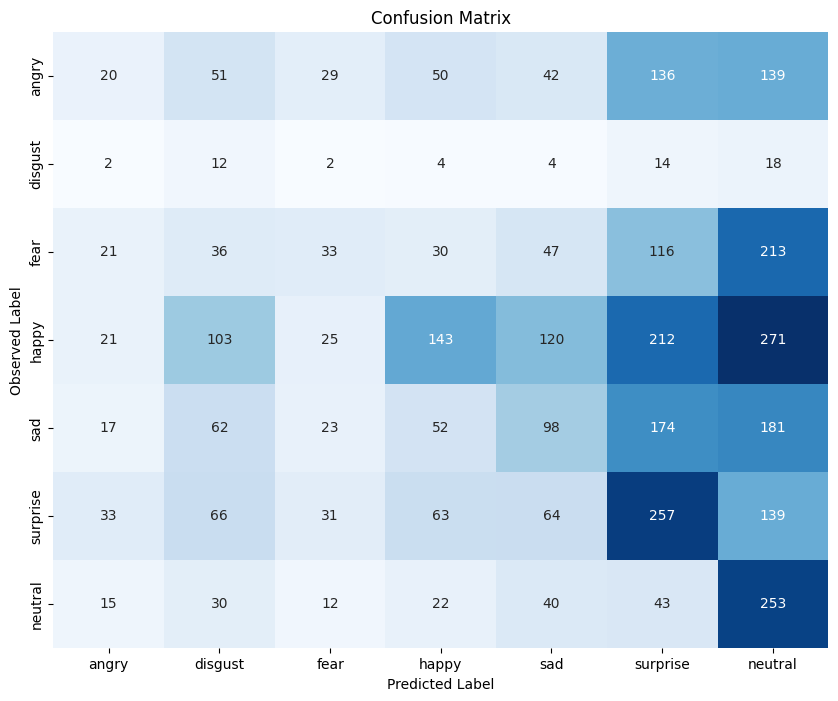

angry Precision: 0.15503875968992248


$$\frac{TP}{TP + FP} \rightarrow \frac{20}{20 + 109} \rightarrow 0.15503875968992248$$

angry Recall: 0.042826552462526764


$$\frac{TP}{TP + FN} \rightarrow \frac{20}{20 + 447} \rightarrow 0.042826552462526764$$

angry Accuracy: 0.8450821955976595


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{20 + 3013}{20 + 3013 + 109 + 447} \rightarrow 0.8450821955976595$$

angry F1 score: 0.06711409395973154


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.15503875968992248 * 0.042826552462526764}{0.15503875968992248 + 0.042826552462526764} \rightarrow 0.06711409395973154$$

disgust Precision: 0.03333333333333333


$$\frac{TP}{TP + FP} \rightarrow \frac{12}{12 + 348} \rightarrow 0.03333333333333333$$

disgust Recall: 0.21428571428571427


$$\frac{TP}{TP + FN} \rightarrow \frac{12}{12 + 44} \rightarrow 0.21428571428571427$$

disgust Accuracy: 0.8907773753134578


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{12 + 3185}{12 + 3185 + 348 + 44} \rightarrow 0.8907773753134578$$

disgust F1 score: 0.057692307692307696


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.03333333333333333 * 0.21428571428571427}{0.03333333333333333 + 0.21428571428571427} \rightarrow 0.057692307692307696$$

fear Precision: 0.2129032258064516


$$\frac{TP}{TP + FP} \rightarrow \frac{33}{33 + 122} \rightarrow 0.2129032258064516$$

fear Recall: 0.06653225806451613


$$\frac{TP}{TP + FN} \rightarrow \frac{33}{33 + 463} \rightarrow 0.06653225806451613$$

fear Accuracy: 0.8370019504040123


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{33 + 2971}{33 + 2971 + 122 + 463} \rightarrow 0.8370019504040123$$

fear F1 score: 0.10138248847926266


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.2129032258064516 * 0.06653225806451613}{0.2129032258064516 + 0.06653225806451613} \rightarrow 0.10138248847926266$$

happy Precision: 0.39285714285714285


$$\frac{TP}{TP + FP} \rightarrow \frac{143}{143 + 221} \rightarrow 0.39285714285714285$$

happy Recall: 0.15977653631284916


$$\frac{TP}{TP + FN} \rightarrow \frac{143}{143 + 752} \rightarrow 0.15977653631284916$$

happy Accuracy: 0.7288938422959041


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{143 + 2473}{143 + 2473 + 221 + 752} \rightarrow 0.7288938422959041$$

happy F1 score: 0.22716441620333597


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.39285714285714285 * 0.15977653631284916}{0.39285714285714285 + 0.15977653631284916} \rightarrow 0.22716441620333597$$

sad Precision: 0.236144578313253


$$\frac{TP}{TP + FP} \rightarrow \frac{98}{98 + 317} \rightarrow 0.236144578313253$$

sad Recall: 0.1614497528830313


$$\frac{TP}{TP + FN} \rightarrow \frac{98}{98 + 509} \rightarrow 0.1614497528830313$$

sad Accuracy: 0.7698523265533574


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{98 + 2665}{98 + 2665 + 317 + 509} \rightarrow 0.7698523265533574$$

sad F1 score: 0.1917808219178082


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.236144578313253 * 0.1614497528830313}{0.236144578313253 + 0.1614497528830313} \rightarrow 0.1917808219178082$$

surprise Precision: 0.2699579831932773


$$\frac{TP}{TP + FP} \rightarrow \frac{257}{257 + 695} \rightarrow 0.2699579831932773$$

surprise Recall: 0.39356814701378257


$$\frac{TP}{TP + FN} \rightarrow \frac{257}{257 + 396} \rightarrow 0.39356814701378257$$

surprise Accuracy: 0.6960156032320981


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{257 + 2241}{257 + 2241 + 695 + 396} \rightarrow 0.6960156032320981$$

surprise F1 score: 0.3202492211838006


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.2699579831932773 * 0.39356814701378257}{0.2699579831932773 + 0.39356814701378257} \rightarrow 0.3202492211838006$$

neutral Precision: 0.20840197693574958


$$\frac{TP}{TP + FP} \rightarrow \frac{253}{253 + 961} \rightarrow 0.20840197693574958$$

neutral Recall: 0.6096385542168675


$$\frac{TP}{TP + FN} \rightarrow \frac{253}{253 + 162} \rightarrow 0.6096385542168675$$

neutral Accuracy: 0.6870994706046253


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{253 + 2213}{253 + 2213 + 961 + 162} \rightarrow 0.6870994706046253$$

neutral F1 score: 0.3106200122774708


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.20840197693574958 * 0.6096385542168675}{0.20840197693574958 + 0.6096385542168675} \rightarrow 0.3106200122774708$$

In [295]:
describe_multiclass_confusion_matrix(multiclass_naive_bayes_model, X_multiclass_test_scaled, y_multiclass_test)

[2 Marks] d. Classify the faces using a support vector machine and report your accuracy.

In [297]:
svm_multiclass_model = None
if train_svm_models:
    svm_multiclass_model, acc = train_svm(X_multiclass_train_scaled, X_multiclass_test_scaled, y_multiclass_train, y_multiclass_test)
    # Save the model
    if train_svm_models:
        joblib.dump(svm_multiclass_model, 'svm_multiclass_model.pkl')
else:
    svm_multiclass_model = joblib.load('svm_multiclass_model.pkl')

Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.
DESCRIBE BRIEFLY HERE

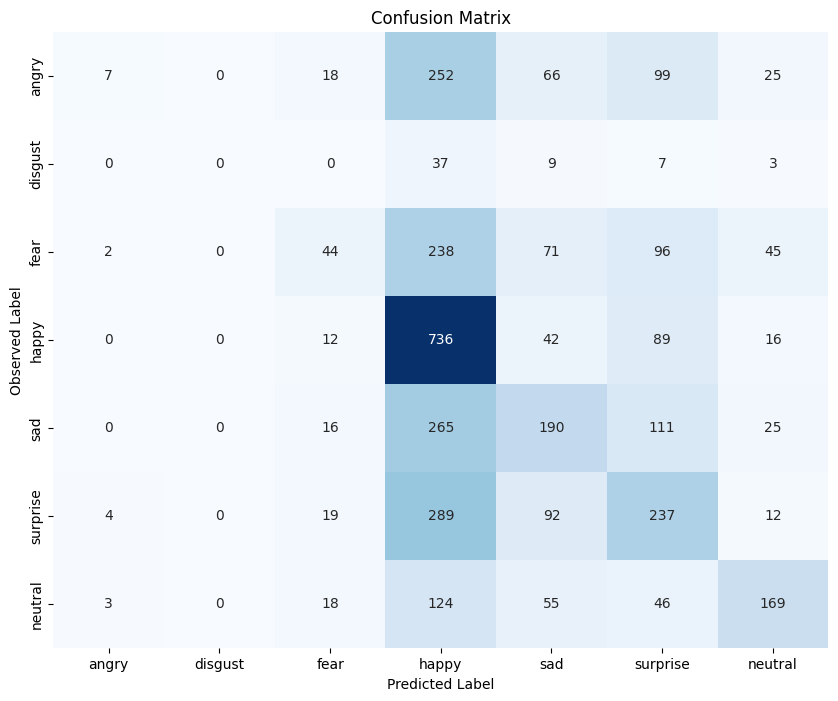

angry Precision: 0.4375


$$\frac{TP}{TP + FP} \rightarrow \frac{7}{7 + 9} \rightarrow 0.4375$$

angry Recall: 0.014989293361884369


$$\frac{TP}{TP + FN} \rightarrow \frac{7}{7 + 460} \rightarrow 0.014989293361884369$$

angry Accuracy: 0.8693229311786013


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{7 + 3113}{7 + 3113 + 9 + 460} \rightarrow 0.8693229311786013$$

angry F1 score: 0.028985507246376812


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.4375 * 0.014989293361884369}{0.4375 + 0.014989293361884369} \rightarrow 0.028985507246376812$$

disgust Precision: 0


$$\frac{TP}{TP + FP} \rightarrow \frac{0}{0 + 0} \rightarrow 0$$

disgust Recall: 0.0


$$\frac{TP}{TP + FN} \rightarrow \frac{0}{0 + 56} \rightarrow 0.0$$

disgust Accuracy: 0.9843967679019225


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{0 + 3533}{0 + 3533 + 0 + 56} \rightarrow 0.9843967679019225$$

disgust F1 score: 0


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0 * 0.0}{0 + 0.0} \rightarrow 0$$

fear Precision: 0.3464566929133858


$$\frac{TP}{TP + FP} \rightarrow \frac{44}{44 + 83} \rightarrow 0.3464566929133858$$

fear Recall: 0.08870967741935484


$$\frac{TP}{TP + FN} \rightarrow \frac{44}{44 + 452} \rightarrow 0.08870967741935484$$

fear Accuracy: 0.8509334076344386


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{44 + 3010}{44 + 3010 + 83 + 452} \rightarrow 0.8509334076344386$$

fear F1 score: 0.14125200642054575


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.3464566929133858 * 0.08870967741935484}{0.3464566929133858 + 0.08870967741935484} \rightarrow 0.14125200642054575$$

happy Precision: 0.3791859866048429


$$\frac{TP}{TP + FP} \rightarrow \frac{736}{736 + 1205} \rightarrow 0.3791859866048429$$

happy Recall: 0.8223463687150838


$$\frac{TP}{TP + FN} \rightarrow \frac{736}{736 + 159} \rightarrow 0.8223463687150838$$

happy Accuracy: 0.6199498467539705


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{736 + 1489}{736 + 1489 + 1205 + 159} \rightarrow 0.6199498467539705$$

happy F1 score: 0.5190409026798307


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.3791859866048429 * 0.8223463687150838}{0.3791859866048429 + 0.8223463687150838} \rightarrow 0.5190409026798307$$

sad Precision: 0.3619047619047619


$$\frac{TP}{TP + FP} \rightarrow \frac{190}{190 + 335} \rightarrow 0.3619047619047619$$

sad Recall: 0.3130148270181219


$$\frac{TP}{TP + FN} \rightarrow \frac{190}{190 + 417} \rightarrow 0.3130148270181219$$

sad Accuracy: 0.7904708832543884


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{190 + 2647}{190 + 2647 + 335 + 417} \rightarrow 0.7904708832543884$$

sad F1 score: 0.33568904593639576


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.3619047619047619 * 0.3130148270181219}{0.3619047619047619 + 0.3130148270181219} \rightarrow 0.33568904593639576$$

surprise Precision: 0.345985401459854


$$\frac{TP}{TP + FP} \rightarrow \frac{237}{237 + 448} \rightarrow 0.345985401459854$$

surprise Recall: 0.36294027565084225


$$\frac{TP}{TP + FN} \rightarrow \frac{237}{237 + 416} \rightarrow 0.36294027565084225$$

surprise Accuracy: 0.7592644190582335


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{237 + 2488}{237 + 2488 + 448 + 416} \rightarrow 0.7592644190582335$$

surprise F1 score: 0.3542600896860986


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.345985401459854 * 0.36294027565084225}{0.345985401459854 + 0.36294027565084225} \rightarrow 0.3542600896860986$$

neutral Precision: 0.5728813559322034


$$\frac{TP}{TP + FP} \rightarrow \frac{169}{169 + 126} \rightarrow 0.5728813559322034$$

neutral Recall: 0.4072289156626506


$$\frac{TP}{TP + FN} \rightarrow \frac{169}{169 + 246} \rightarrow 0.4072289156626506$$

neutral Accuracy: 0.8963499582056283


$$\frac{TP + TN}{TP + TN + FP + FN} \rightarrow \frac{169 + 3048}{169 + 3048 + 126 + 246} \rightarrow 0.8963499582056283$$

neutral F1 score: 0.476056338028169


$$2*\frac{Precision * Recall}{Precision + Recall} \rightarrow \frac{0.5728813559322034 * 0.4072289156626506}{0.5728813559322034 + 0.4072289156626506} \rightarrow 0.476056338028169$$

In [298]:
describe_multiclass_confusion_matrix(svm_multiclass_model, X_multiclass_test_scaled, y_multiclass_test)

[2 Marks] e. Which categories of faces seem to be most similar or least similar?
EXPLAIN HERE

[4 Marks] f. Let's assume that some of the faces were labeled wrong in producing the dataset. Propose and implement a solution that identifies images that are potentially mislabeled. Show 10 samples based on the method you choose.

In [299]:
# YOUR CODE HERE

# Optional

From all the classification approaches considered above, choose one to score faces based on a continuous valued prediction of for each of the categories.

[No Marks] a. Produce a prediction for each face in the test set (this has 7 dimensions). Visualize these based on a 2D embedding of the scores. The "data points" plotted in the embedding should show the actual picture of the face, at the corresponding 2D point location. (You could consider using t-SNE for your embedding)

In [300]:
# YOUR CODE HERE

[{'n_components': 2, 'pca': array([0.29155556, 0.09284025]), 'lda': array([0.34684495, 0.2054046 ])}, {'n_components': 3, 'pca': array([0.29155556, 0.09284025, 0.09099685]), 'lda': array([0.34684495, 0.2054046 , 0.13566668])}, {'n_components': 4, 'pca': array([0.29155556, 0.09284025, 0.09099685, 0.05238226]), 'lda': array([0.34684495, 0.2054046 , 0.13566668, 0.11307777])}, {'n_components': 5, 'pca': array([0.29155556, 0.09284025, 0.09099685, 0.05238226, 0.02790959]), 'lda': array([0.34684495, 0.2054046 , 0.13566668, 0.11307777, 0.10552274])}]


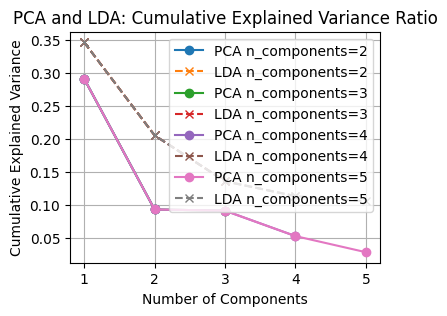

In [301]:
def compare_incremental_pca():

    data = []
    for i in range(2, 6):
        
        # PCA
        pca = PCA(n_components=i)
        pca.fit_transform(X_multiclass_train_scaled)
        pca_explained_variance_ratio = pca.explained_variance_ratio_

        # LDA
        lda = LDA(n_components=i)
        lda.fit_transform(X_multiclass_train_scaled, y_multiclass_train)
        lda_explained_variance_ratio = lda.explained_variance_ratio_


        data.append({
            "n_components": i,
            "pca": pca_explained_variance_ratio,
            "lda": lda_explained_variance_ratio
        })
    
    print(data)

    # Create the plot
    plt.figure(figsize=(4, 3))
    for entry in data:
        plt.plot(range(1, entry["n_components"] + 1), entry["pca"], marker='o', label=f'PCA n_components={entry["n_components"]}')
        plt.plot(range(1, entry["n_components"] + 1), entry["lda"], marker='x', label=f'LDA n_components={entry["n_components"]}', linestyle='--')
    
    plt.title('PCA and LDA: Cumulative Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid(True)
    plt.show()

compare_incremental_pca()

The first component capture about 29% of the variance, the second about 9%, to sum 38% (0.38)